In [1]:
pip install pydicom umap-learn torch torchvision matplotlib pandas


Note: you may need to restart the kernel to use updated packages.


In [5]:
# ============================================================
# 0. Imports & configuration
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from PIL import Image

import umap.umap_ as umap

# For cleaner plots
plt.rcParams["figure.dpi"] = 120

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [6]:
# ============================================================
# 1. Point this to your DICOM folder
#    Example structure:
#    /path/to/data/case01/
#         slice_001.dcm
#         slice_002.dcm
#         ...
# ============================================================

DATA_DIR = "/Users/laporchiadavis/Desktop/SACS-Updated Capstone BurnCare Dataset & Images/Capstone Flow/Dataset Bone CT Scans/Original/DICOM/LowerLimb/PartRight/Case5"   # <<< CHANGE THIS >>>


In [7]:
# ============================================================
# 2. DICOM Images
#    - reads .dcm
#    - applies VOI LUT if present
#    - rescales to 0–1
#    - converts to 8-bit RGB for CNN
# ============================================================

# Use fully qualified name to avoid NameError if Dataset wasn't imported in this kernel.
class SingleCaseDicomDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None, extensions=(".dcm",)):
        self.img_dir = img_dir
        self.transform = transform
        self.extensions = extensions

        self.image_paths = [
            os.path.join(img_dir, f)
            for f in sorted(os.listdir(img_dir))
            if f.lower().endswith(self.extensions)
        ]

        if len(self.image_paths) == 0:
            raise ValueError(f"No DICOM images found in {img_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]

        # ---- 1. Read DICOM ----
        ds = pydicom.dcmread(path)

        # ---- 2. Get pixel data & apply VOI LUT if possible ----
        pixel_array = ds.pixel_array
        try:
            pixel_array = apply_voi_lut(pixel_array, ds)
        except Exception:
            pass  # OK if no VOI LUT

        # ---- 3. Rescale to 0–1 ----
        pixel_array = pixel_array.astype(np.float32)
        min_val, max_val = pixel_array.min(), pixel_array.max()
        if max_val > min_val:
            pixel_array = (pixel_array - min_val) / (max_val - min_val)
        else:
            pixel_array = np.zeros_like(pixel_array, dtype=np.float32)

        # ---- 4. Convert to uint8 for PIL ----
        pixel_uint8 = (pixel_array * 255).clip(0, 255).astype(np.uint8)

        # ---- 5. Grayscale -> RGB ----
        pil_img = Image.fromarray(pixel_uint8)  # "L"
        pil_img = pil_img.convert("RGB")

        # ---- 6. Torchvision transforms ----
        if self.transform:
            img = self.transform(pil_img)
        else:
            img = pil_img

        return img, path


# Instantiate dataset after the class is defined.
# Use DATA_DIR defined in a previous cell. Add a simple transform suitable for CNNs.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

ds = SingleCaseDicomDataset(DATA_DIR, transform=transform)
img, path = ds[0]
print(type(img), path)


<class 'torch.Tensor'> /Users/laporchiadavis/Desktop/SACS-Updated Capstone BurnCare Dataset & Images/Capstone Flow/Dataset Bone CT Scans/Original/DICOM/LowerLimb/PartRight/Case5/1.dcm


In [8]:
# ============================================================
# 3. Transforms + DataLoader
#    (ImageNet normalization for ResNet)
# ============================================================

img_size = 224

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

dataset = SingleCaseDicomDataset(DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

print("Number of DICOMs:", len(dataset))
for _, p in [dataset[0]]:
    print("Example file:", p)


Number of DICOMs: 72
Example file: /Users/laporchiadavis/Desktop/SACS-Updated Capstone BurnCare Dataset & Images/Capstone Flow/Dataset Bone CT Scans/Original/DICOM/LowerLimb/PartRight/Case5/1.dcm


In [9]:
# ============================================================
# 4. Load pretrained ResNet-50 as feature extractor
#    (no training, no epochs)
# ============================================================

resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Remove final FC layer: keep everything up to avgpool
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

# No gradients needed
for p in feature_extractor.parameters():
    p.requires_grad = False


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/laporchiadavis/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 53.0MB/s]


In [10]:
# ============================================================
# 5. Extract CNN features for all slices
# ============================================================

all_features = []
all_paths = []

with torch.no_grad():
    for imgs, paths in dataloader:
        imgs = imgs.to(device)

        feats = feature_extractor(imgs)      # (B, 2048, 1, 1)
        feats = feats.view(feats.size(0), -1)  # (B, 2048)

        all_features.append(feats.cpu().numpy())
        all_paths.extend(list(paths))

features = np.concatenate(all_features, axis=0)  # (N_images, 2048)
print("Feature matrix shape:", features.shape)


Feature matrix shape: (72, 2048)


In [11]:
# ============================================================
# 6. UMAP on feature matrix (2D for visualization)
# ============================================================

reducer = umap.UMAP(
    n_components=2,
    metric="euclidean",
    n_neighbors=10,
    min_dist=0.1,
    random_state=42,
)

embedding_2d = reducer.fit_transform(features)
print("UMAP embedding shape:", embedding_2d.shape)


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (72, 2)


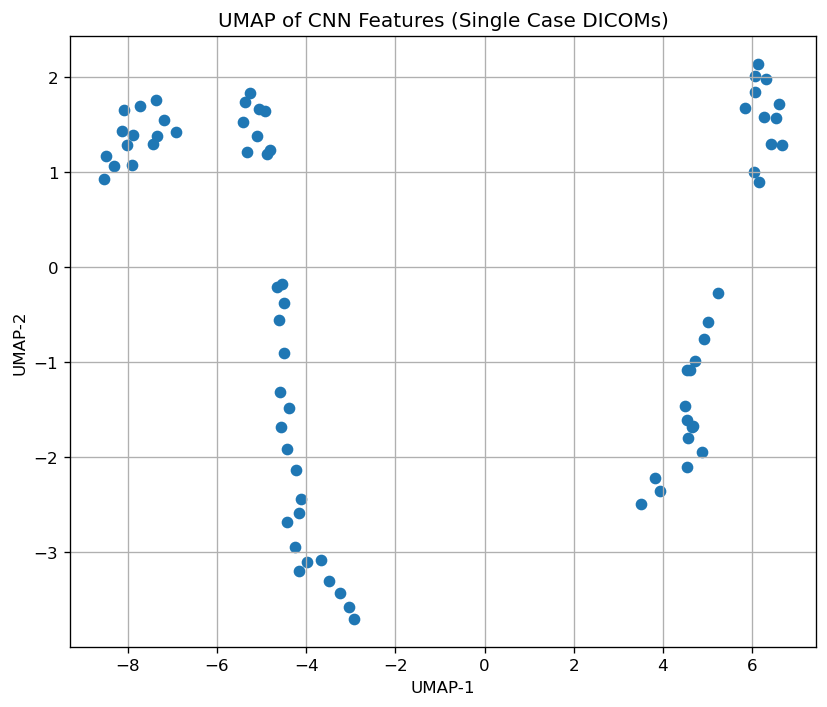

In [12]:
# ============================================================
# 7. Basic 2D scatter plot of embeddings
# ============================================================

plt.figure(figsize=(7, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1])
plt.title("UMAP of CNN Features (Single Case DICOMs)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()


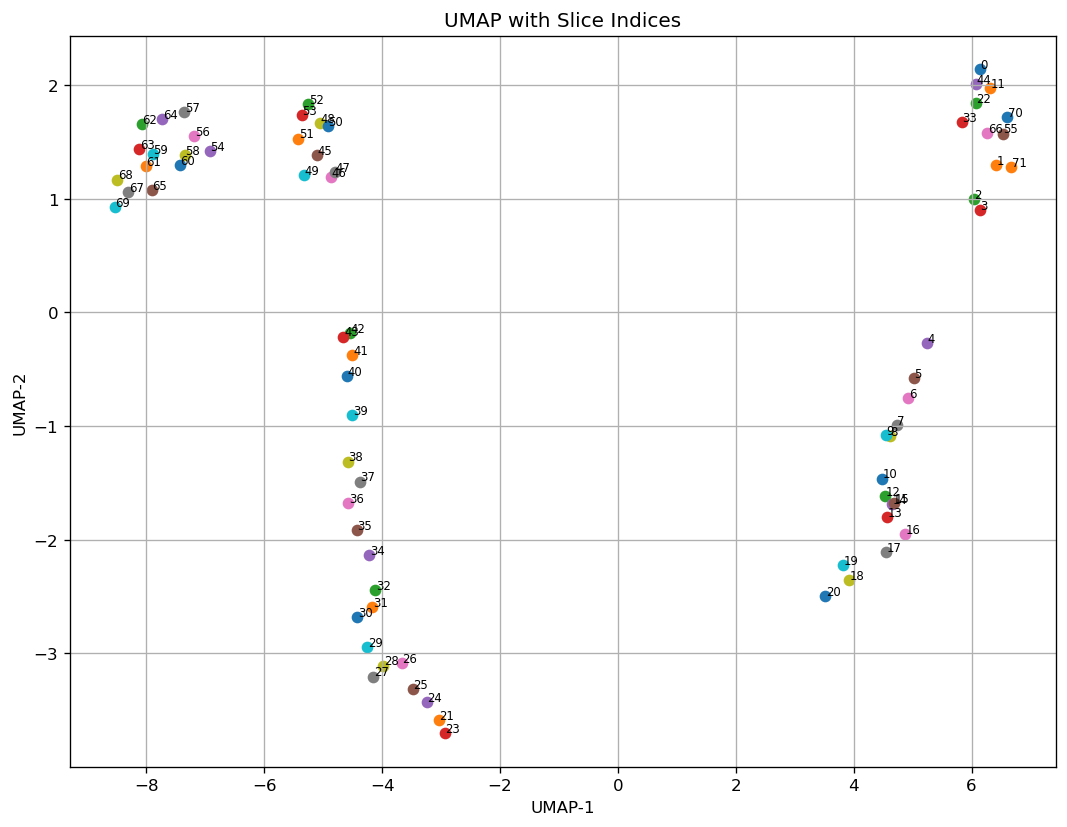

In [13]:
# ============================================================
# 8. Plot with labels (index of slice)
# ============================================================

plt.figure(figsize=(9, 7))
for i, (x, y) in enumerate(embedding_2d):
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, str(i), fontsize=7)

plt.title("UMAP with Slice Indices")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# ============================================================
# 9. Save embedding + paths for your report / analysis
# ============================================================

import tempfile

out_csv = "case05_dicom_cnn_umap_embedding.csv"

# Try saving to working dir first; if filesystem is read-only, fall back to temp dir.
try:
    df_embed.to_csv(out_csv, index=False)
    print(f"Saved embedding CSV to: {out_csv}")
except OSError as e:
    # Handle read-only filesystem by writing to temp directory instead
    if getattr(e, "errno", None) == 30 or "Read-only file system" in str(e):
        tmp_dir = tempfile.gettempdir()
        alt_path = os.path.join(tmp_dir, out_csv)
        df_embed.to_csv(alt_path, index=False)
        print(f"Warning: could not write to '{out_csv}' ({e}).")
        print(f"Saved embedding CSV to temp directory instead: {alt_path}")
    else:
        # Re-raise unexpected IO errors
        raise
        

Saved embedding CSV to temp directory instead: /var/folders/tb/3td38qsd63g03vn8qyj25c2m0000gn/T/case05_dicom_cnn_umap_embedding.csv


Let's read images from each cluster region 

In [18]:


import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Folder that contains 1.dcm, 22.dcm, 23.dcm, 45.dcm, 46.dcm, 72.dcm
DATA_DIR = "/Users/laporchiadavis/Desktop/SACS-Updated Capstone BurnCare Dataset & Images/Capstone Flow/Dataset Bone CT Scans/Original/DICOM/LowerLimb/PartRight/Case5"   


In [19]:
def load_dicom_image(path):
    """Read a DICOM file and return a 2D numpy array scaled to [0, 1]."""
    ds = pydicom.dcmread(path)
    
    # Get raw pixel data
    img = ds.pixel_array.astype(np.float32)
    
    # Apply VOI LUT if available (better windowing for CT/MR)
    try:
        img = apply_voi_lut(img, ds)
    except Exception:
        pass

    # Normalize to 0–1
    min_val, max_val = img.min(), img.max()
    if max_val > min_val:
        img = (img - min_val) / (max_val - min_val)
    else:
        img = np.zeros_like(img, dtype=np.float32)

    return img


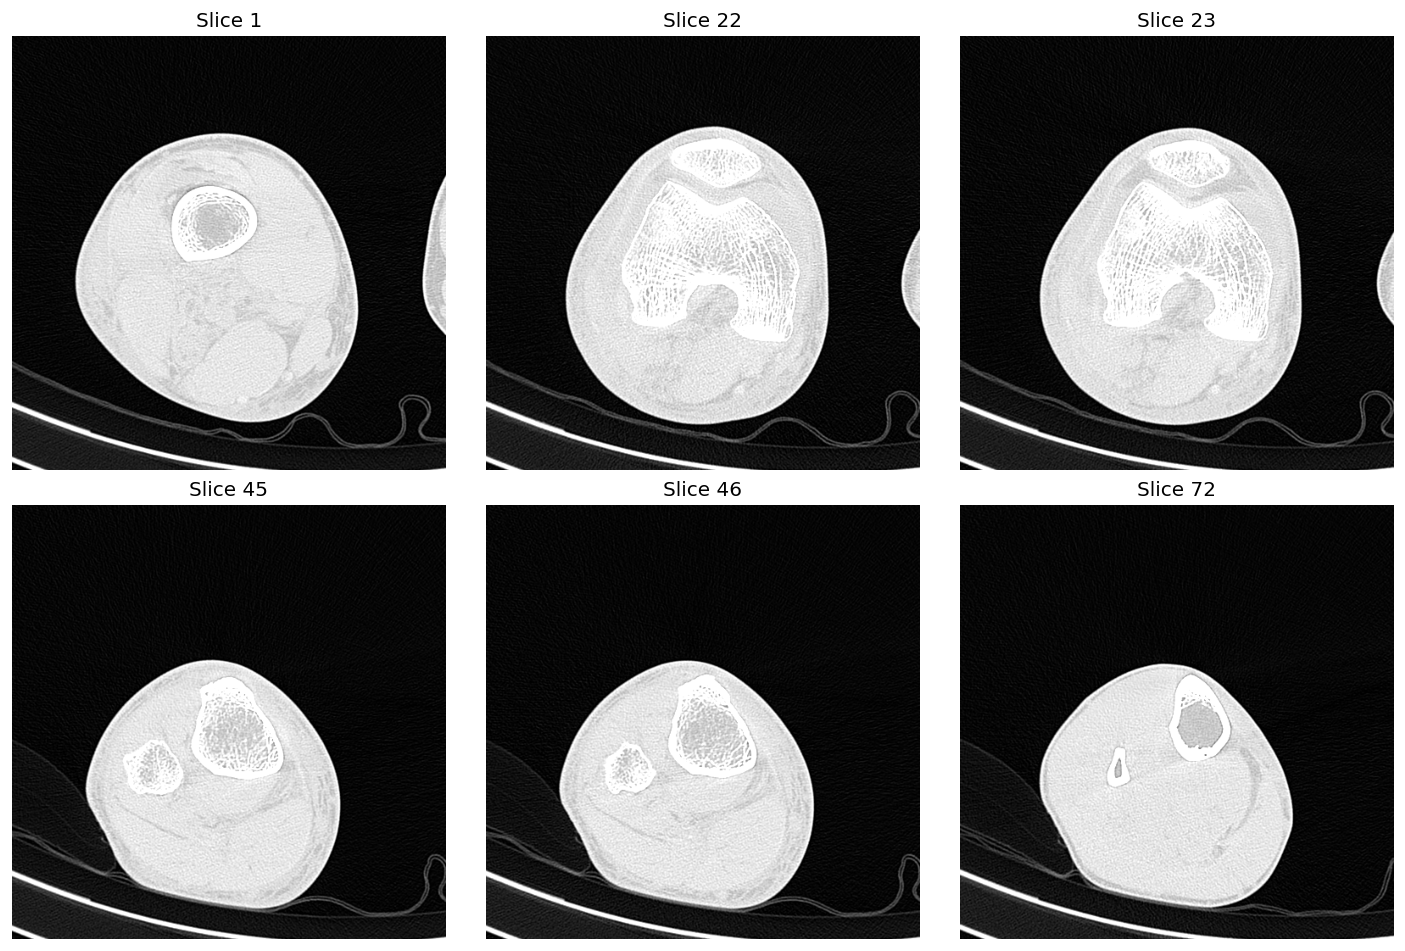

In [20]:
# Slices you picked from different regions / clusters
slice_numbers = [1, 22, 23, 45, 46, 72]

# Make a 2 x 3 grid
n = len(slice_numbers)
rows, cols = 2, 3

fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()

for ax, sn in zip(axes, slice_numbers):
    dicom_path = os.path.join(DATA_DIR, f"{sn}.dcm")  # assumes filename like "1.dcm"
    img = load_dicom_image(dicom_path)
    
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Slice {sn}")
    ax.axis("off")

# If fewer than 6 slices, hide extra axes
for ax in axes[len(slice_numbers):]:
    ax.axis("off")

plt.tight_layout()
plt.show()
